In [130]:
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from __future__ import unicode_literals
from collections import Counter
from math import *
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVR
import eli5
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report, f1_score,accuracy_score ,confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
import matplotlib.gridspec as gridspec
from sklearn.impute import KNNImputer
import seaborn as sns
import warnings
from warnings import simplefilter
import ast
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [131]:
train_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/test.csv")
store_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/store.csv")

In [132]:
def RMSPE(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

### Archivos:
* **train.csv** - datos histórico incluyendo Sales
* **test.csv** - datos histórico excluyendo Sales
* **sample_submission.csv** - ejemplo del formato que debe tener el submission a Kaggle 
* **store.csv** - información suplementaria sobre las tiendas

### Campos:
Descripción de los campos menos descriptivos

* **Id** - Id único para cada par de Store y Date
* **Store** - Id unívoco para cada tienda
* **Sales** - ventas para cada día dado. Variable target
* **Customers** - cantidad de clientes para un día dado
* **Open** - variable binaria que indica si la tienda esta abierta o no: 0 = cerrada, 1 = abierta
* **StateHoliday** - indica si se trata de un feriado estatal. Normalmente las tienfas estan cerradas durante los feriados: a = feriado, b = Pascuas, c = Navidad, 0 = ninguna. 
* **SchoolHoliday** - indica si la dupla Tienda, fecha es afectada por el cierre de las esceulas. 
* **StoreType** - diferentes modelos de tiendas: a, b, c, d
* **Assortment** - grado de provisionamiento: a = basic, b = extra, c = extended
* **CompetitionDistance** - distancia en metros a la tienda del competidor mas cercano. 
* **CompetitionOpenSince**[Month/Year] - año y mes en que abrió el competidor más cercano.
* **Promo** - indica si la tienda tiene una promoción ese día o no.
* **Promo2** - Promo2 indica si la tienda esta participa de promociones consecutivas: 0 = la tienda no participa, 1 = tienda participa
* **Promo2Since**[Year/Week] - indica la semana y año en la que la tienda comenzó a participar de Promo2
* **PromoInterval** - meses en los que comienza Promo2. Por ejemplo: "Feb,May,Aug,Nov" significa que la ronda de promociones comienza en Febrero, Mayo, Agosto y Noviembre. 

In [133]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [134]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [135]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [136]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [137]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [138]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


### Combinacion de ambos datasets

In [139]:
train_df = train_df.merge(store_df, how='left', on='Store') #this is gonna be the merged training dataset
test_df = test_df.merge(store_df, how='left', on='Store') #this is gonna be the merged testing dataset

In [140]:
ID = test_df['Id']
test_df.drop('Id',inplace=True,axis=1)

train_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)
test_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)

for dataset in (train_df,test_df):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Day'] = dataset.Date.dt.day
    dataset['Month'] = dataset.Date.dt.month
    dataset['Year'] = dataset.Date.dt.year
    dataset['DayOfYear'] = dataset.Date.dt.dayofyear
    dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    dataset.set_index('Date', inplace=True)

In [141]:
train_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,1,2013,1,1
2013-01-02,1,3,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,1,2013,2,1
2013-01-03,1,4,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,1,2013,3,1
2013-01-04,1,5,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,1,2013,4,1
2013-01-05,1,6,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,1,2013,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1115,1,10712,608,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",27,7,2015,208,31
2015-07-28,1115,2,8093,500,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",28,7,2015,209,31
2015-07-29,1115,3,7661,473,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",29,7,2015,210,31


In [142]:
import calendar

def get_day_of_week(day_number):
    # Los días de la semana en el módulo de calendario están indexados comenzando en 0 (0 es lunes)
    day_name = calendar.day_name[int(day_number) - 1]
    return day_name

In [143]:
# Creas una nueva columna 'DayName' aplicando la función a la columna 'DayNumber'
train_df['DayName'] = train_df['DayOfWeek'].apply(get_day_of_week)
test_df['DayName'] = test_df['DayOfWeek'].apply(get_day_of_week)

# Análisis exploratorio

### Variables numéricas

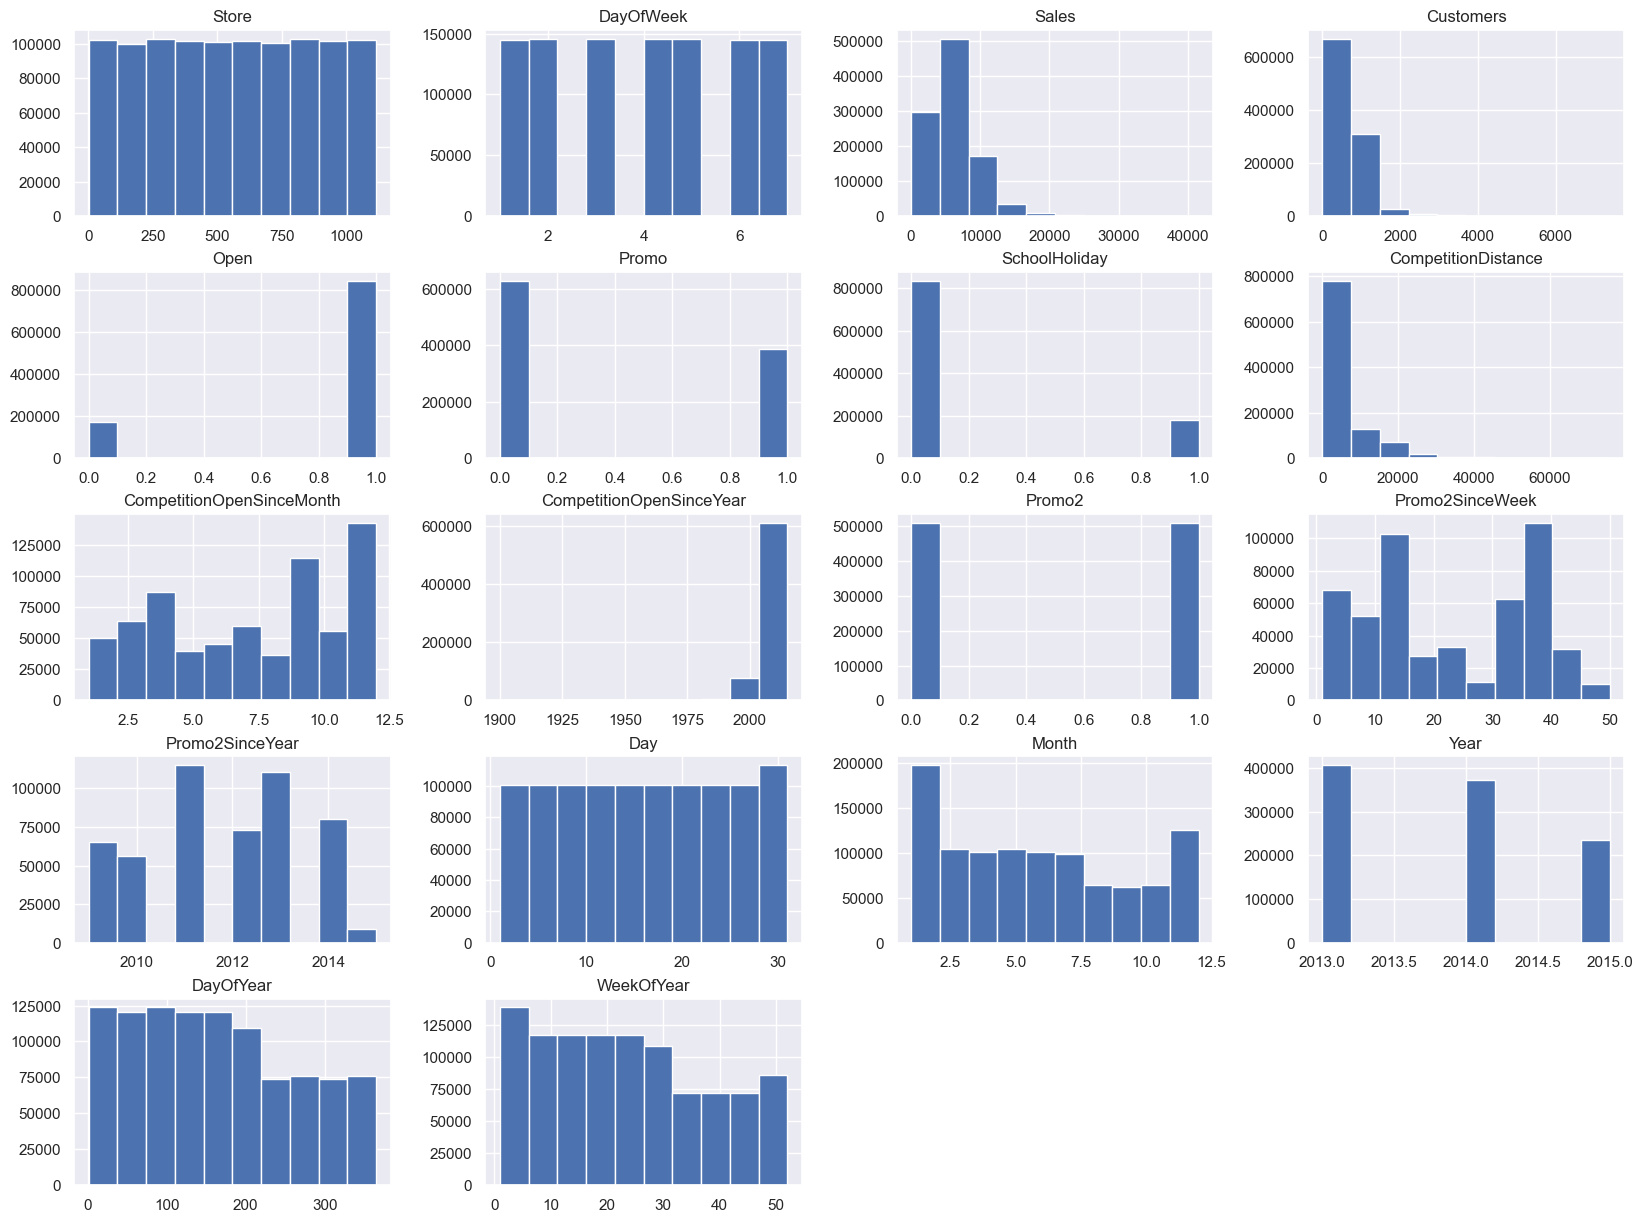

In [144]:
# Histograma de las variables numericas (Train)
numerical_features = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[numerical_features].hist(figsize=(20,15));

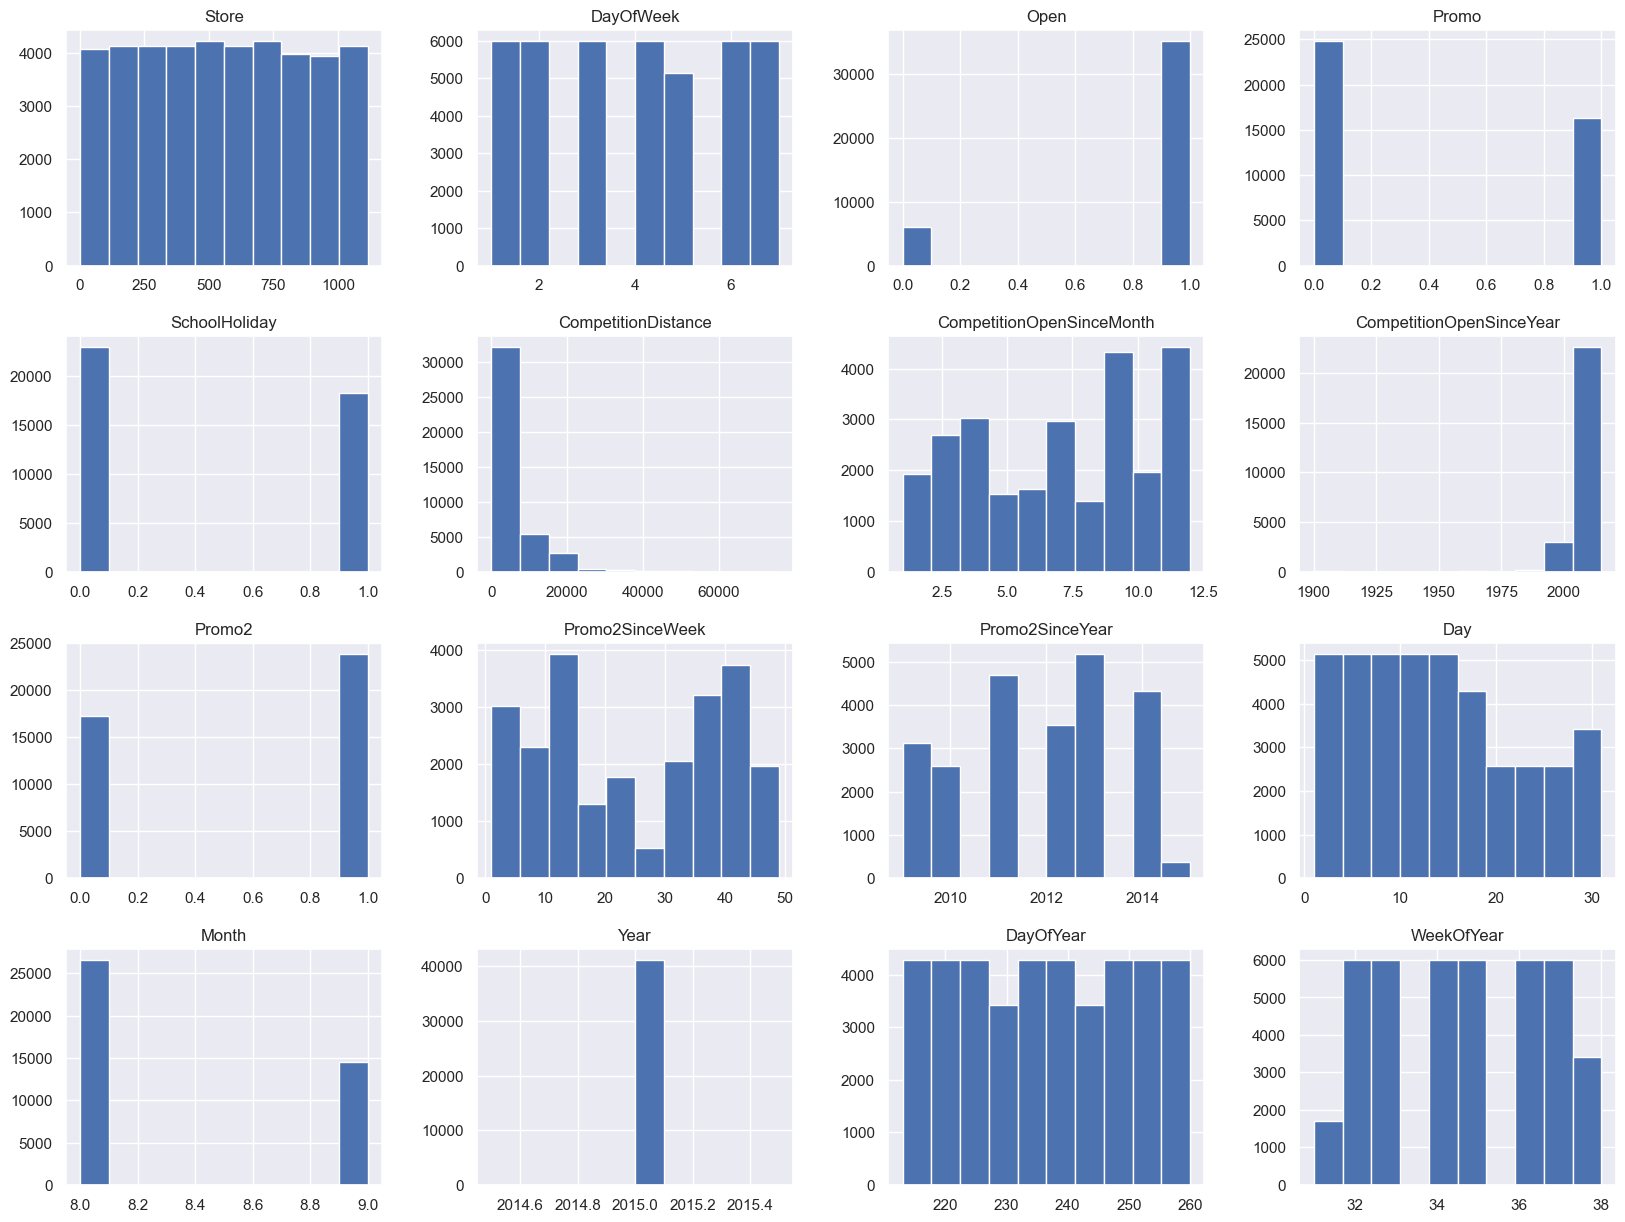

In [145]:
#Numerical Features Histograms (Test)
numerical_features = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[numerical_features].hist(figsize=(20,15));

In [146]:
numerical_features

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Day',
 'Month',
 'Year',
 'DayOfYear',
 'WeekOfYear']

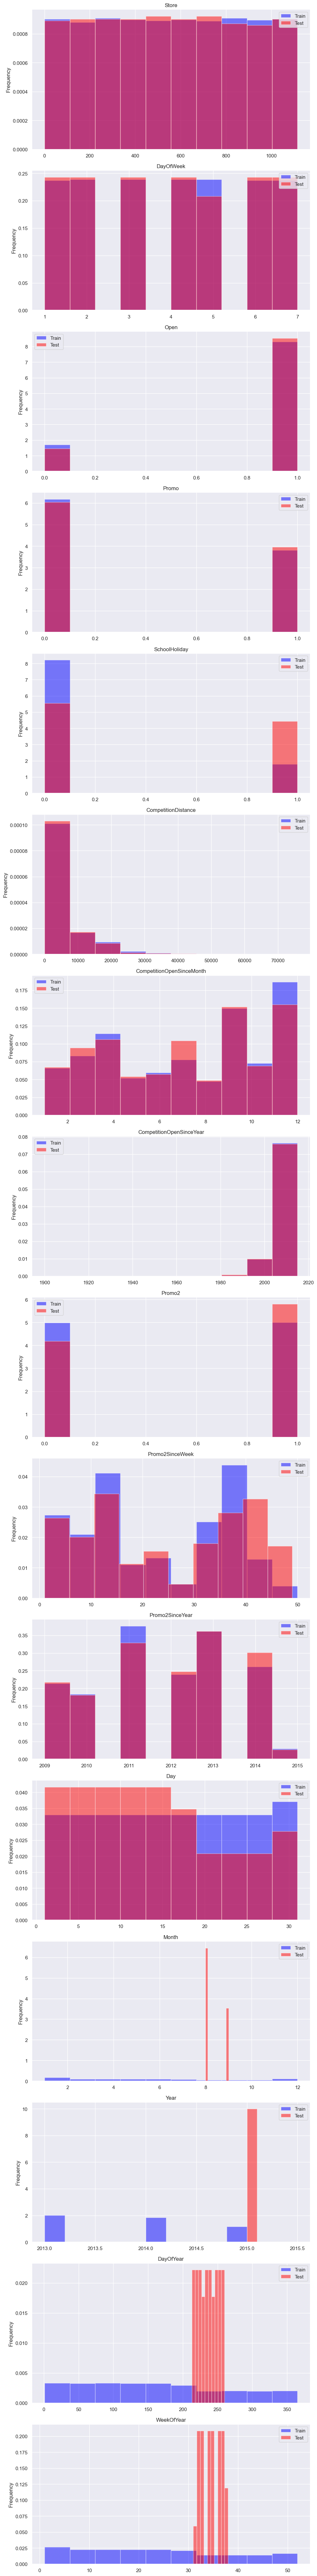

In [147]:
# Características numéricas
# Se usan solo las variables de test porque train tiene variables que test no posee
numerical_features = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)

# Crea una figura y un conjunto de subgráficos
fig, axs = plt.subplots(len(numerical_features), figsize=(10, 5*len(numerical_features)))

# Para cada característica numérica
for i, feature in enumerate(numerical_features):
    # Histograma de entrenamiento
    train_df[feature].plot(kind='hist', density=True, alpha=0.5, ax=axs[i], color='blue', label='Train')
    
    # Histograma de prueba
    test_df[feature].plot(kind='hist', density=True, alpha=0.5, ax=axs[i], color='red', label='Test')
    
    # Título y leyenda
    axs[i].set_title(feature)
    axs[i].legend()

# Muestra la figura
plt.tight_layout()
plt.show()

El dataset de test no posee la variable __Customers__ por lo que no puede ser usada directamente el entrenamiento. Aunque potencialmente se podría usar para agrupar las tiendas. 

Para las demás variables la distribución es bastante similar entre dataset con la excepción de __SchoolHoliday__, dónde el dataset de test tiene una mayor frecuencia de 1s. 

In [148]:
# Casteo de variables numericas y categóricas
numeric_cols = ['Store', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear']
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment', 'Promo', 'SchoolHoliday',
                   'Promo2']

train_df[categorical_cols] = train_df[categorical_cols].astype(str)
test_df[categorical_cols] = test_df[categorical_cols].astype(str)

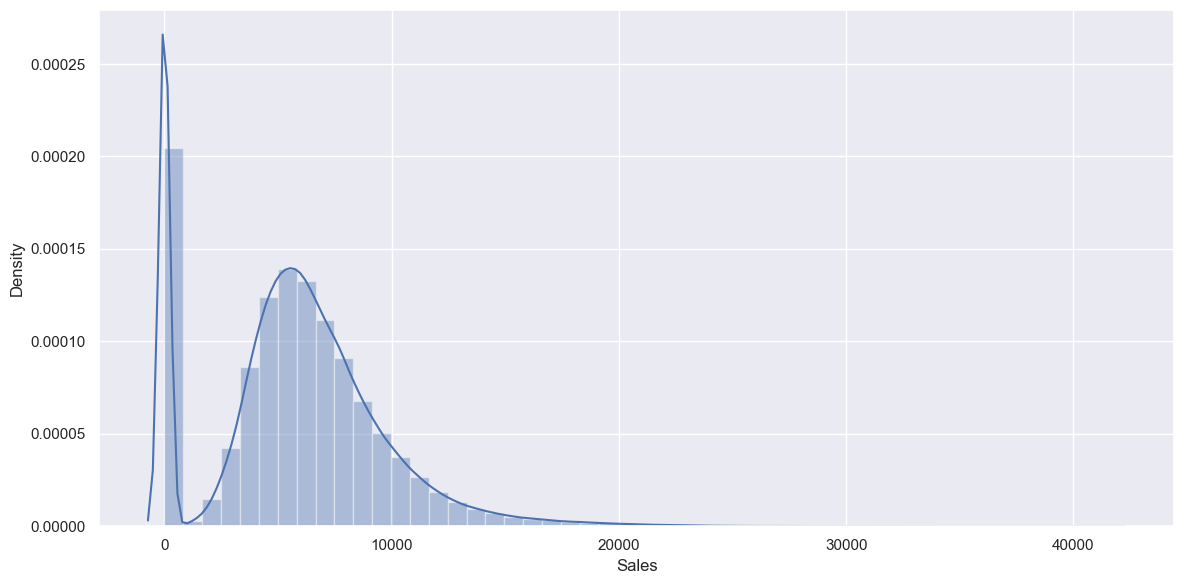

In [149]:
# Plot a histogram of the Sales column
plt.figure(figsize=(12,6))
ax = sns.distplot(train_df["Sales"])
plt.tight_layout()
plt.show()

La distribución de la variable ventas es bastante peculiar. Por un lado existen una gran cantidad de valores 0, hecho que podría ser explicado por otras variables. Por otro lado, la distribución de los valores positivos es relativamente simétrico en cuanto a la similitud de la media y mediana, aunque con una cola muy pesada hacia la derecha. 

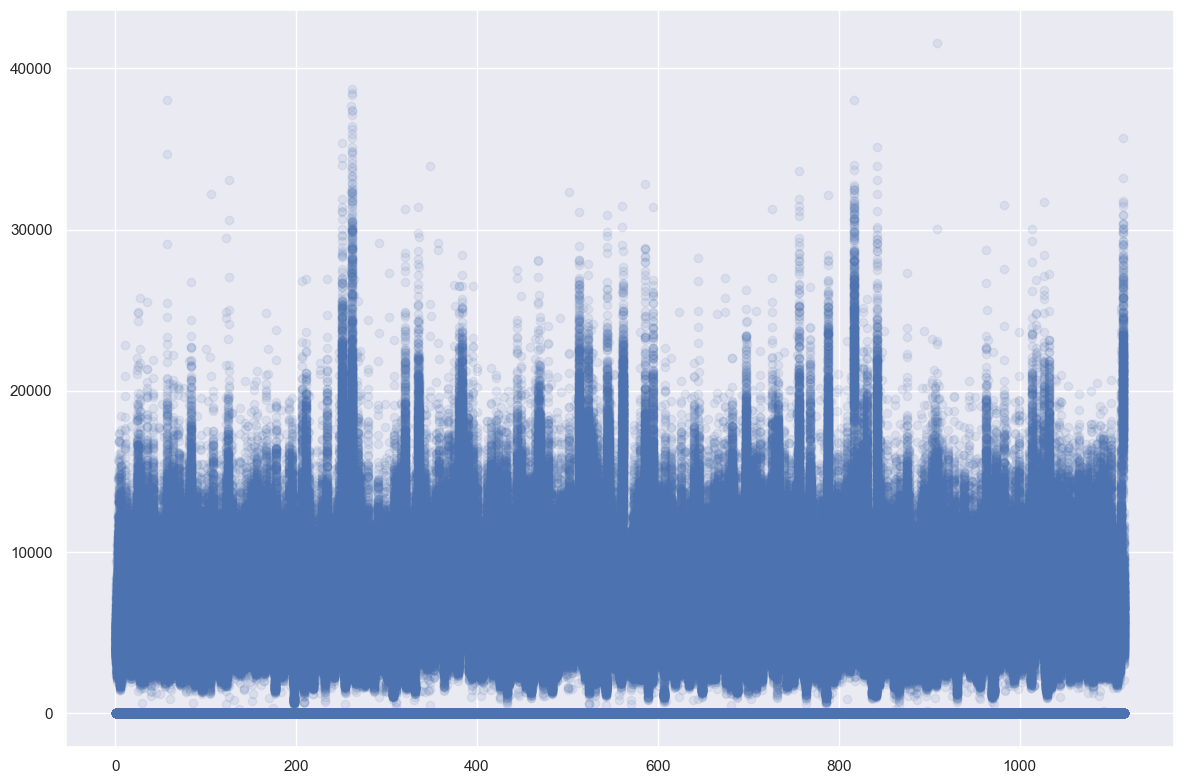

In [150]:
#Sales_Stores
plt.figure(figsize=(12, 8))
plt.scatter(train_df['Store'],train_df['Sales'], alpha=0.1);
plt.tight_layout()

Nuevamente se ve que hay muchas tiendas con ventas por encima de los 18000-20000 mientras que también que una gran cantidad tienen valores de 0, lo que podría indicar que las tiendas están cerradas. 

In [151]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

La alta densidad de valores de 0 clientes confirma que las ventas nulas se deben a que la tienda estuvo cerrada. Es necesario identificar el motivo por el cuál la tienda estuvo cerrada. Las variables relacionadas a las vacaciones o feriados y a tienda cerrada podrían explicar este comportamiento.

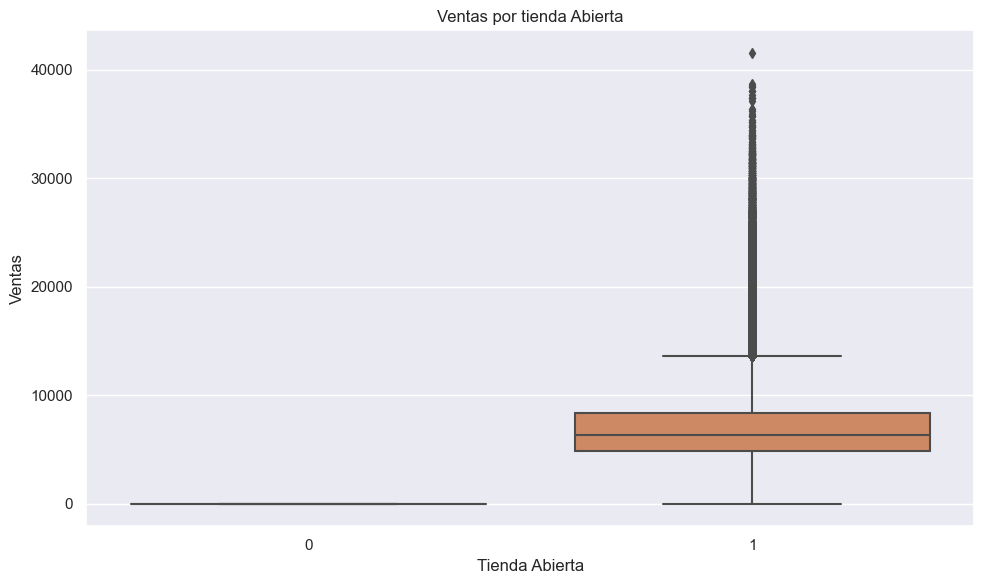

In [152]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="Open", y="Sales")
ax.set_title("Ventas por tienda Abierta")
ax.set_xlabel("Tienda Abierta")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

Como era de esperarse, cuando la tienda está cerrada, las ventas son cero. Sin embargo, cuando está abierta existe una gran dispersión en las ventas. Es necesario identificar cuáles otras variables podrían estar actuando. 

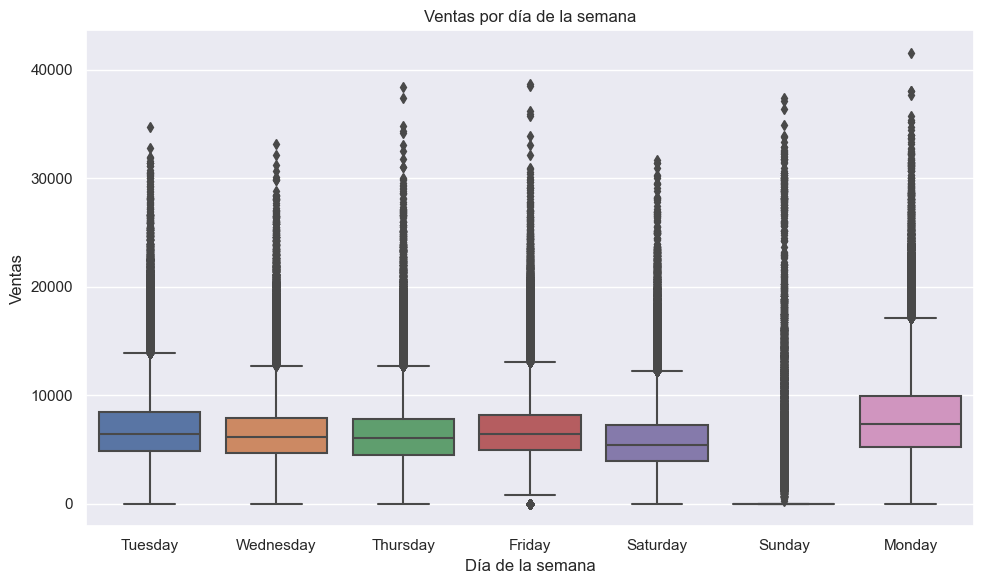

In [153]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="DayName", y="Sales")
ax.set_title("Ventas por día de la semana")
ax.set_xlabel("Día de la semana")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

Las ventas son relativamente similares durante toda la semana a excepción del domingo. Una proporción importante de las tiendas permanece cerrada ese dia aunque si hay algunas ventas por alguna razón. 

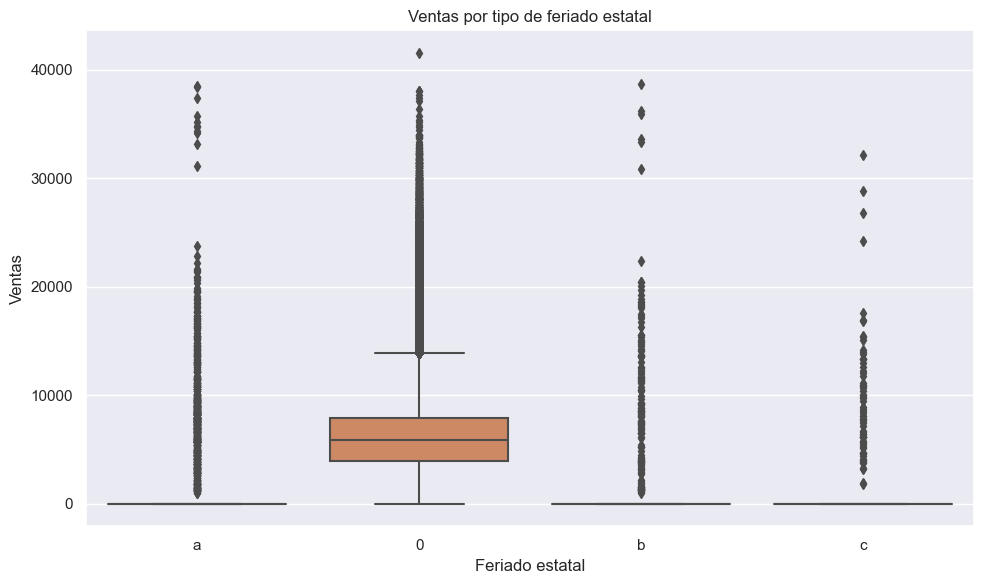

In [154]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="StateHoliday", y="Sales")
ax.set_title("Ventas por tipo de feriado estatal")
ax.set_xlabel("Feriado estatal")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

No hay una diferencia importante entre los distintos tipos de feriados estatales, aunque lógicamente cuando no los hay, las tiendas tienen ventas positivas. 

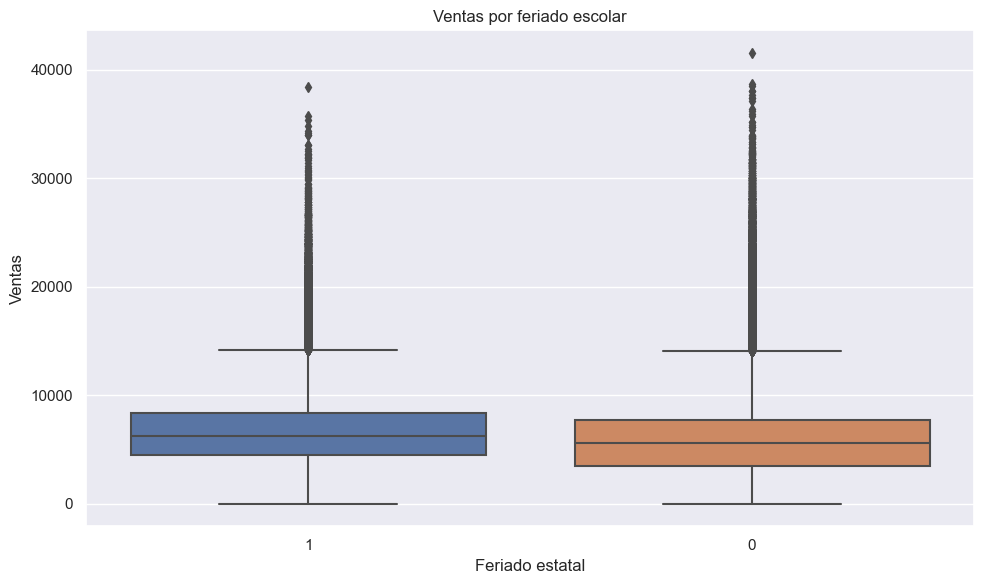

In [155]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="SchoolHoliday", y="Sales")
ax.set_title("Ventas por feriado escolar")
ax.set_xlabel("Feriado estatal")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

Los feriados escolares parecen no tener un mayor efecto sobre las ventas a nivel agregado. Esto no quiere decir que para algunas tiendas en particular esta variable no sea útil. 

**A partir del análisis anterior se podría pensar que cuando se dan ciertas condiciones, como feriados estatales, las ventas podrían harcodearse a 0. Esta afirmación es un poco temeraria y deberia ser comprobada.**

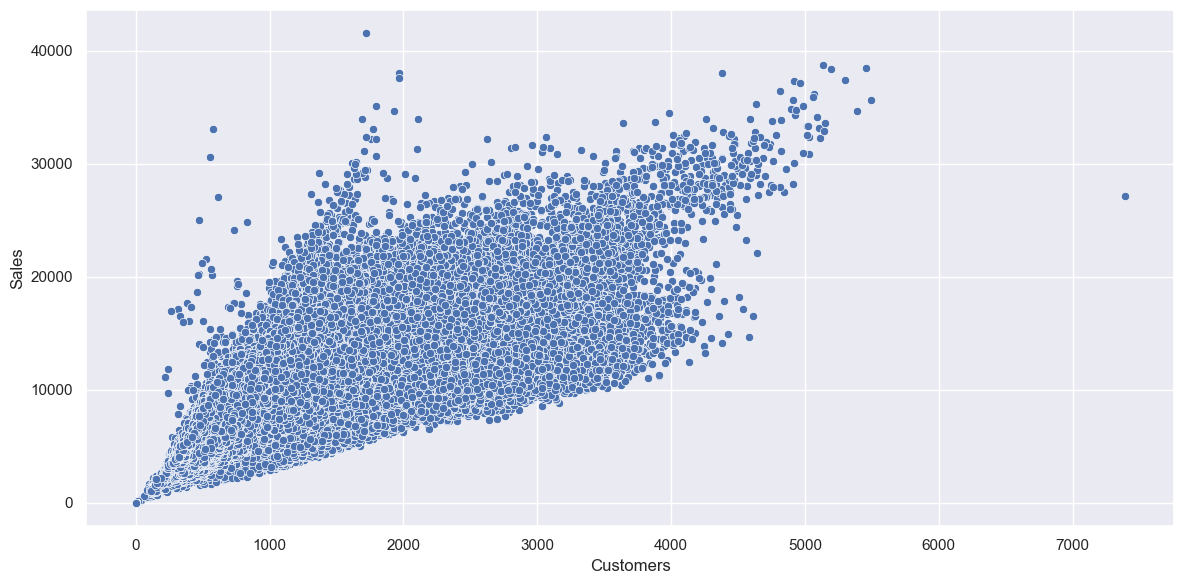

In [156]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = train_df["Customers"],y=train_df["Sales"])
plt.tight_layout()

Existe una relación positiva y bastante lineal entre $Sales$ y $Customers$, esto es bastante lógico ya que a mayor cantidad de clientes, las ventas totales son mayores. La forma de abanico de los distribución hace pensar que el ticket promedio por día y por tienda es muy diferente, especialmente hacia las colas de las distribuciones. Esta podría ser una variable interesante a incluir. 

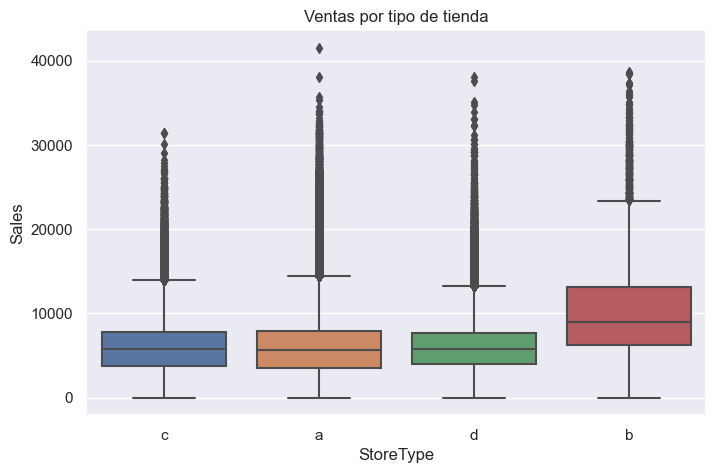

In [157]:
# Ventas por tipo de tienda
plt.figure(figsize=(8,5))
sns.boxplot(data=train_df, x="StoreType", y="Sales")
plt.title("Ventas por tipo de tienda")
plt.xlabel("StoreType")
plt.ylabel("Sales")
plt.show()

El tipo de tienda _b_ es diferente a los demás y tiene ventas por encima de las demás. Seria interesante explorar si los tickets promedio de estas tiendas también son mayores y explicaria la variabilidad mostrada en el diagrama de dispersión anterior. 

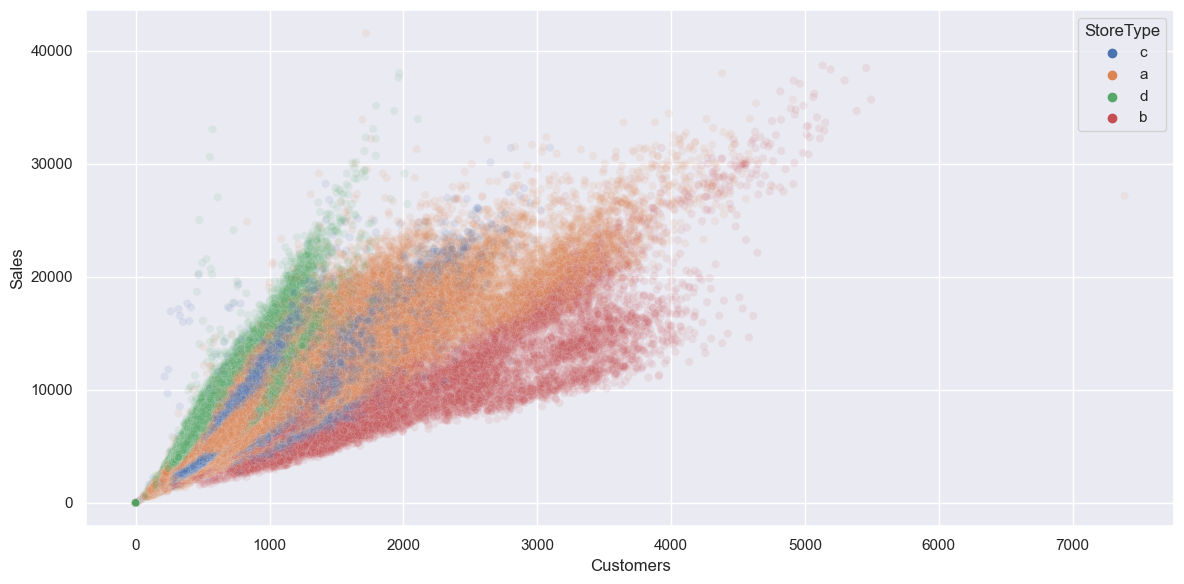

In [158]:
plt.figure(figsize=(12,6))

# Para crear colores distintos para cada StoreType
#colors = {'a':'red', 'b':'blue', 'c':'green', 'd':'yellow'}

sns.scatterplot(x=train_df["Customers"], y=train_df["Sales"], hue=train_df['StoreType'], alpha = 0.1)
plt.tight_layout()
plt.show()


Se puede ver una clara diferencia entre los tipos de tienda. Las tiendas _b_ tienden a tener menos ventas diarias pero una mayor cantidad de clientes. En el otro extremo, las tiendas _d_ tienen menos clientes pero una mayor cantidad de ventas lo que indica un mayor ticket promedio. 

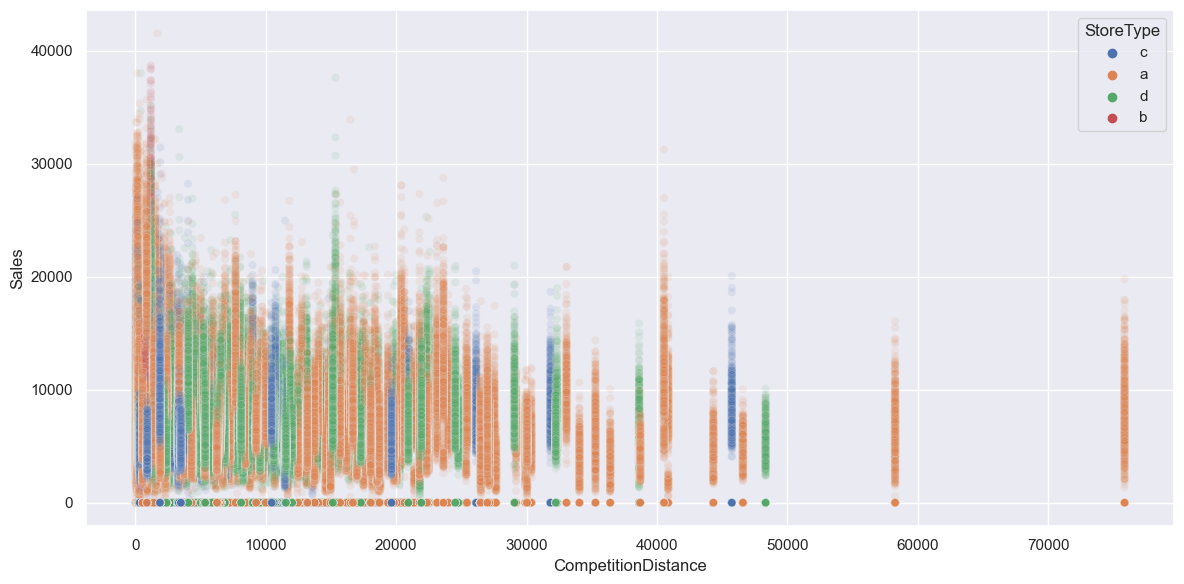

In [159]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = train_df["CompetitionDistance"],y=train_df["Sales"], hue=train_df['StoreType'], alpha = 0.1)
plt.tight_layout()

Parecería no existir una relación negativa entre la distancia de la competencia y las ventas. Aún a distancias cortas se dan ventas muy altas y otras más bajas. 

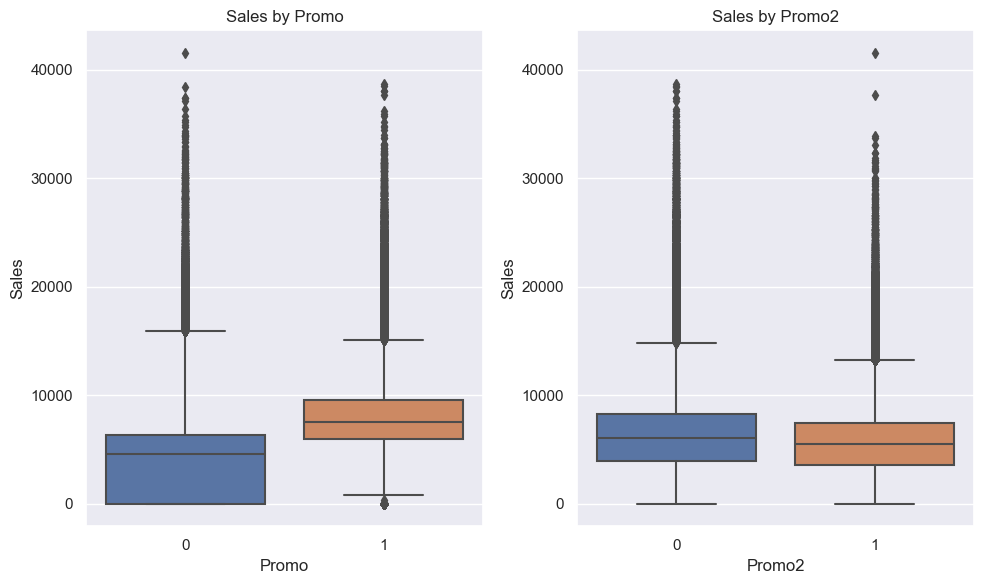

In [160]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(data=train_df, x="Promo", y="Sales", ax=axes[0])
axes[0].set_title("Sales by Promo")
axes[0].set_xlabel("Promo")
axes[0].set_ylabel("Sales")

sns.boxplot(data=train_df, x="Promo2", y="Sales", ax=axes[1])
axes[1].set_title("Sales by Promo2")
axes[1].set_xlabel("Promo2")
axes[1].set_ylabel("Sales")

fig.tight_layout()
plt.show()


Las promociones afectan positivamente a las ventas. Es decir, cuando una tienda ofrece una promoción, las ventas aumentan. Sin embargo, cuando la promoción continua, como indica _Promo2_, las ventas no se modifican o incluso disminuyen. Sería interesante conocer el motivo detrás de esto. Una posibilidad sería que luego de la primer promoción la cantidad de clientes disminuya porque ya han realizado sus compras sirviéndose de los primeros descuentos. 

In [161]:
ventas_promo2 = train_df.groupby(by='Promo2')['Sales','Customers'].sum().assign(SalesPerCustomer = lambda x: x['Sales'] / x['Customers'])
ventas_promo2

,Sales,Customers,SalesPerCustomer
Promo2,,,
0,3111542628,357125490,8.712743
1,2761637995,286916265,9.625240


Al evaluar la sumatoria de las ventas se ve que su disminución se debe a la menor afluencia de clientes. Sería necesario explorar el motivo de esta disminución. 

### Analisis de la temporalidad

<Axes: xlabel='Day', ylabel='Sales'>

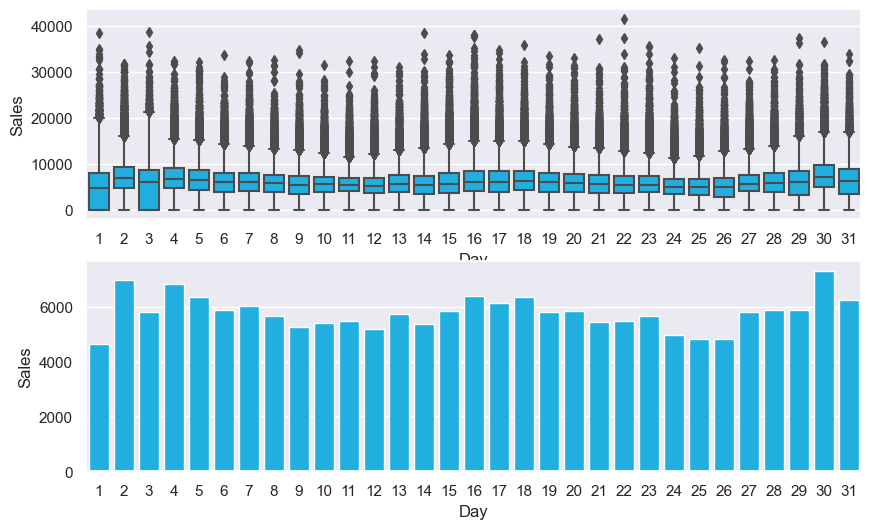

In [162]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

day_df = train_df.groupby("Day")["Sales"].mean().to_frame().reset_index()
# Boxplot
sns.boxplot(x=train_df["Day"],y=train_df["Sales"], color="deepskyblue", ax=axes[0])
# Barplot
sns.barplot(x=day_df["Day"],y=day_df["Sales"], color="deepskyblue", ax=axes[1])


Las ventas son relativamente parejas dentro de cada mes. Aunque los dias 1 y 3 son los únicos con al menos un 25% de valores de 0. Sería interesante ver qué sucede esos dias. Por otro lado, los outliers parece tener una ligera estacionalidad quincenal. 

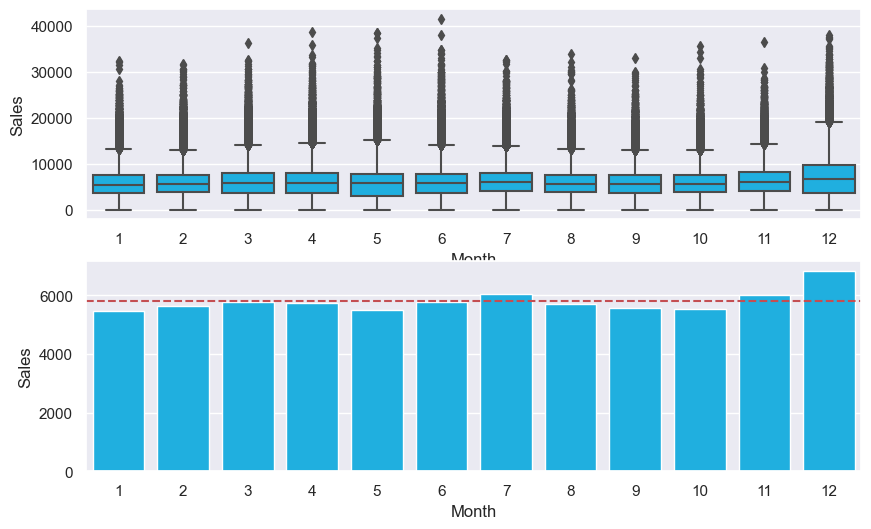

In [163]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

month_df = train_df.groupby("Month")["Sales"].mean().to_frame().reset_index()
# Boxplot
sns.boxplot(x=train_df["Month"],y=train_df["Sales"], color="deepskyblue", ax=axes[0])
# Barplot
sns.barplot(x=month_df["Month"],y=month_df["Sales"], color="deepskyblue", ax=axes[1])

# Adding average line
average_sales = month_df["Sales"].mean()
axes[1].axhline(average_sales, color='r', linestyle='--')

plt.show()


Las ventas durante el año no parecen tener una estacionalidad marcada. Si el mes de diciembre, en coincidencia con la Navidad, presenta las mayores ventas, aunque también la mayor variabilidad durante el año. Las ventas de Noviembre, Julio también se encuentran por encima de la media. 

<Axes: xlabel='Year', ylabel='Sales'>

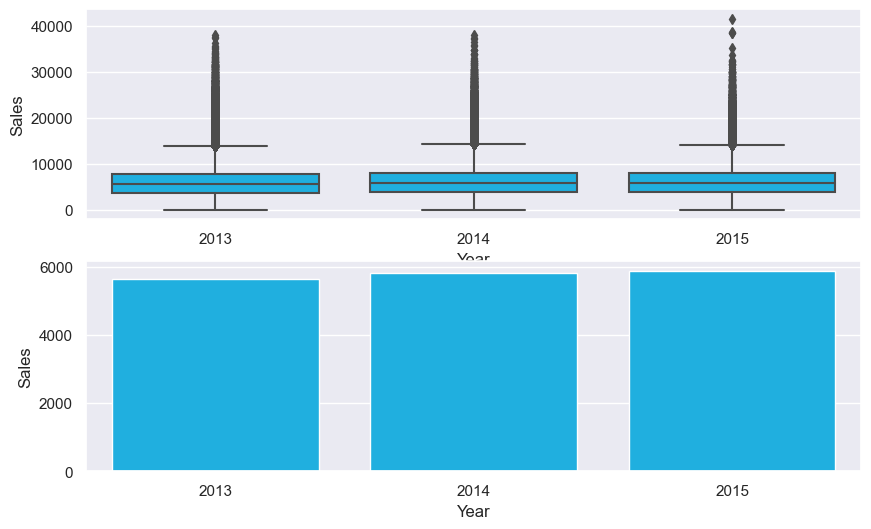

In [164]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

year_df = train_df.groupby("Year")["Sales"].mean().to_frame().reset_index()
# Boxplot
sns.boxplot(x=train_df["Year"],y=train_df["Sales"], color="deepskyblue", ax=axes[0])
# Barplot
sns.barplot(x=year_df["Year"],y=year_df["Sales"], color="deepskyblue", ax=axes[1])


Las ventas parecen aumentar con los años pero se trata de una diferencia muy sutil. 

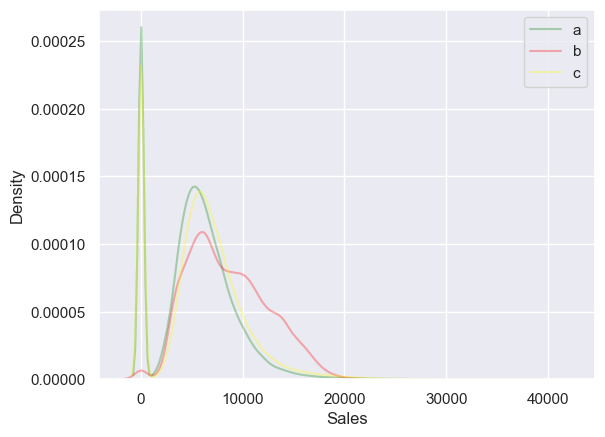

In [165]:
sns.set()
sns.kdeplot(train_df[train_df['Assortment'] == 'a'].Sales, color='green', alpha=0.3, label = 'a')
sns.kdeplot(train_df[train_df['Assortment'] == 'b'].Sales, color='red', alpha=0.3, label = 'b')
sns.kdeplot(train_df[train_df['Assortment'] == 'c'].Sales, color='yellow', alpha=0.3, label = 'c')
plt.legend()
plt.show()

Las tiendas con _Assorment_ tipo "b" parecen tienen menos ventas que las demás. 

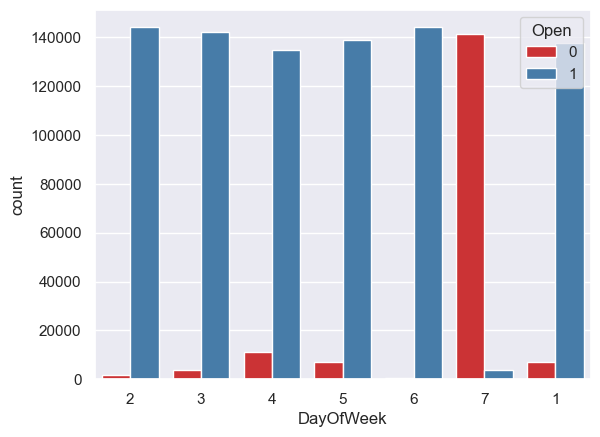

In [166]:
# Cantidad de tiendas abiertas por dia de la semana
sns.countplot( x='DayOfWeek', data=train_df, hue="Open", palette="Set1");

Casi todas las tiendas están cerradas durante el fin de semana. Esto confirma que el dia 7 de la semana se corresponde con el domingo. 

<Axes: >

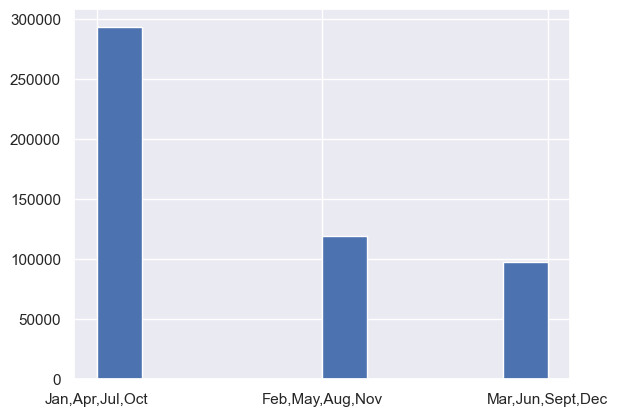

In [167]:
# Histograma de PromoInterval
train_df['PromoInterval'].hist()

La gran mayoría de las promociones se concentran en los meses de enero, abril, julio y octubre. 

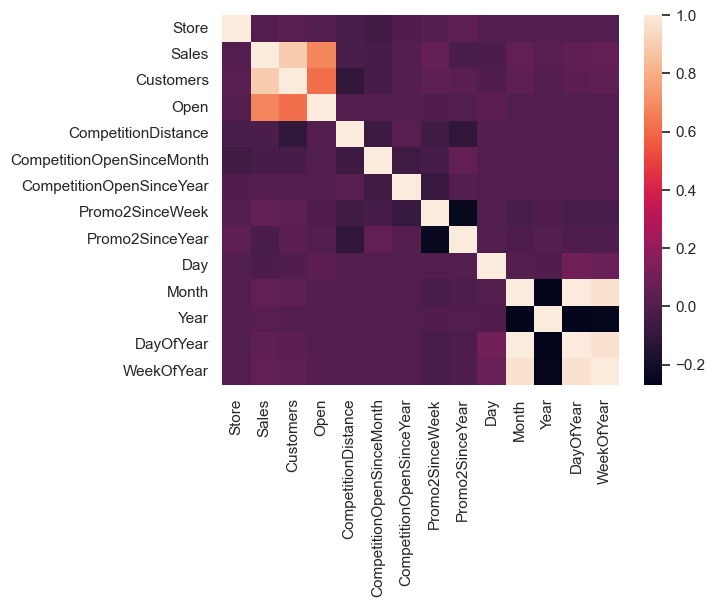

In [168]:
sns.heatmap(train_df.corr())
plt.show()

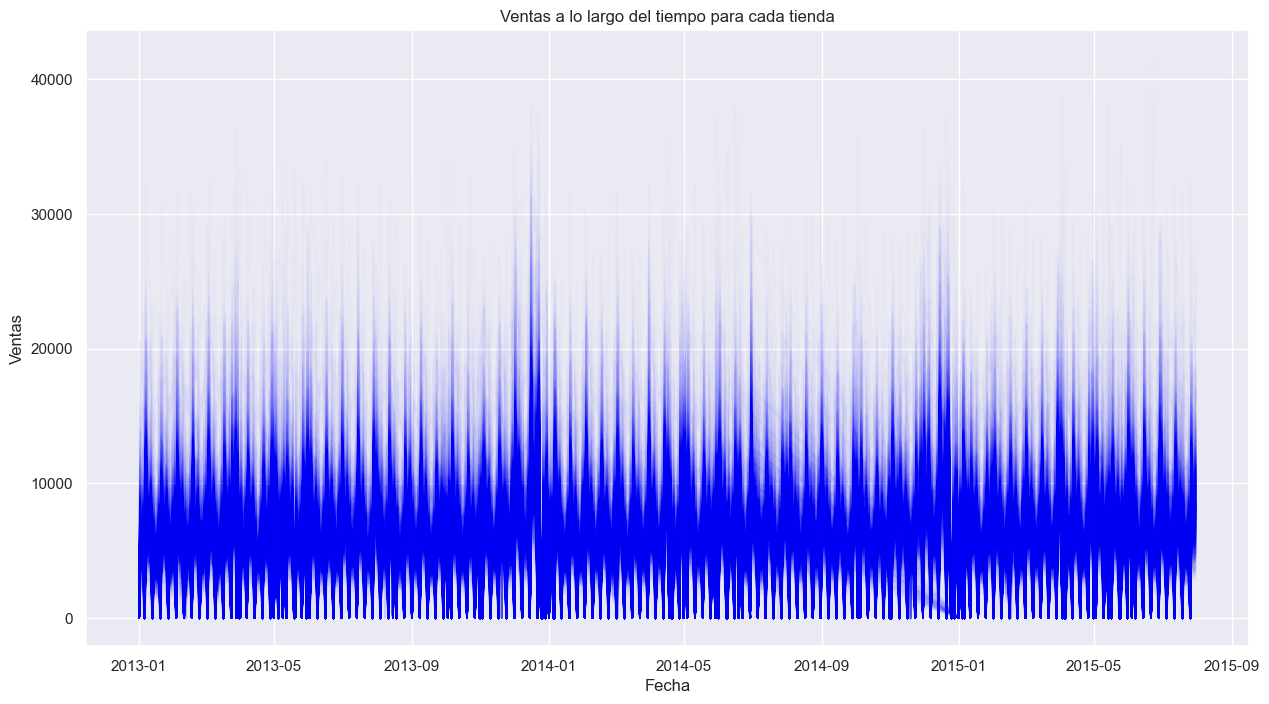

In [169]:
import matplotlib.pyplot as plt

# Crea una lista de todas las tiendas únicas
stores = train_df['Store'].unique()

plt.figure(figsize=(15, 8))

# Itera sobre cada tienda y traza las ventas de esa tienda
for store in stores:
    store_df = train_df[train_df['Store'] == store]
    plt.plot(store_df.index, store_df['Sales'], color='blue', alpha=0.01)

plt.title('Ventas a lo largo del tiempo para cada tienda')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()


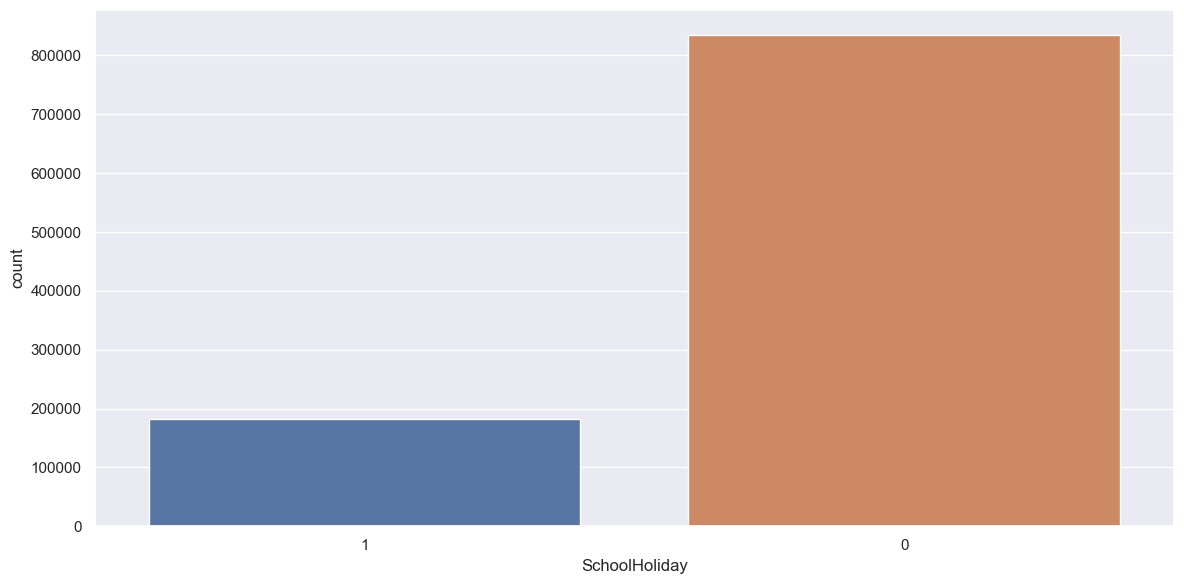

In [170]:
plt.figure(figsize=(12,6))
sns.countplot(x = train_df["SchoolHoliday"])
plt.tight_layout()

# Feature engineering

In [171]:
store_data = train_df.groupby('Store').agg({
    'Sales': ['sum', 'mean', 'min', 'max', 'median', 'std'], 
    'Customers': ['sum', 'mean', 'min', 'max', 'median', 'std'], 
    'Open': 'count'
}).reset_index()

# Flatten the MultiIndex in the columns for easier access
store_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in store_data.columns.values]

# Rename the columns to indicate they are aggregated by store
store_data.rename(columns={
    'Store': 'Store',
    'Sales_sum': 'Store_Sales_Sum',
    'Sales_mean': 'Store_Sales_Avg',
    'Sales_min': 'Store_Sales_Min',
    'Sales_max': 'Store_Sales_Max',
    'Sales_median': 'Store_Sales_Median',
    'Sales_std': 'Store_Sales_Std',
    'Customers_sum': 'Store_Customers_Sum',
    'Customers_mean': 'Store_Customers_Avg',
    'Customers_min': 'Store_Customers_Min',
    'Customers_max': 'Store_Customers_Max',
    'Customers_median': 'Store_Customers_Median',
    'Customers_std': 'Store_Customers_Std',
    'Open_count': 'Store_Open_Days'
}, inplace=True)

# Calculate the necessary metrics
# Calculate the necessary metrics
store_data['Store_Avg_Sales_Per_Customer'] = store_data['Store_Sales_Sum'] / store_data['Store_Customers_Sum']  # Average sales per customer


In [172]:
train_df = train_df.merge(store_data)
test_df = test_df.merge(store_data)

In [173]:
train_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,DayName,Store_Sales_Sum,Store_Sales_Avg,Store_Sales_Min,Store_Sales_Max,Store_Sales_Median,Store_Sales_Std,Store_Customers_Sum,Store_Customers_Avg,Store_Customers_Min,Store_Customers_Max,Store_Customers_Median,Store_Customers_Std,Store_Open_Days,Store_Avg_Sales_Per_Customer
0,1,2,0,0,0,0,a,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,1,2013,1,1,Tuesday,3716854,3945.704883,0,9528,4373.5,2015.417840,440523,467.646497,0,1130,529.0,228.930850,942,8.437366
1,1,3,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,1,2013,2,1,Wednesday,3716854,3945.704883,0,9528,4373.5,2015.417840,440523,467.646497,0,1130,529.0,228.930850,942,8.437366
2,1,4,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,1,2013,3,1,Thursday,3716854,3945.704883,0,9528,4373.5,2015.417840,440523,467.646497,0,1130,529.0,228.930850,942,8.437366
3,1,5,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,1,2013,4,1,Friday,3716854,3945.704883,0,9528,4373.5,2015.417840,440523,467.646497,0,1130,529.0,228.930850,942,8.437366
4,1,6,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,1,2013,5,1,Saturday,3716854,3945.704883,0,9528,4373.5,2015.417840,440523,467.646497,0,1130,529.0,228.930850,942,8.437366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,1,10712,608,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",27,7,2015,208,31,Monday,4922229,5225.296178,0,12491,5671.0,2847.822847,337884,358.687898,0,893,401.0,183.507566,942,14.567807
1017205,1115,2,8093,500,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",28,7,2015,209,31,Tuesday,4922229,5225.296178,0,12491,5671.0,2847.822847,337884,358.687898,0,893,401.0,183.507566,942,14.567807
1017206,1115,3,7661,473,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",29,7,2015,210,31,Wednesday,4922229,5225.296178,0,12491,5671.0,2847.822847,337884,358.687898,0,893,401.0,183.507566,942,14.567807
1017207,1115,4,8405,502,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",30,7,2015,211,31,Thursday,4922229,5225.296178,0,12491,5671.0,2847.822847,337884,358.687898,0,893,401.0,183.507566,942,14.567807


In [174]:

import pandas as pd
import statsmodels.api as sm

def stl_decompose(df, store, period=30):
    # Selecciona las ventas de la tienda específica
    sales = df[df['Store'] == store]['Sales']
    
    # Realiza la descomposición STL
    result = sm.tsa.seasonal_decompose(sales, model='additive', period=period)
    
    # Agrega los componentes al DataFrame original
    #df.loc[df['Store'] == store, 'trend'] = result.trend.values
    df.loc[df['Store'] == store, 'seasonal'] = result.seasonal.values
    #df.loc[df['Store'] == store, 'resid'] = result.resid.values
    
    return df

# Aplica la función a cada tienda
for store in train_df['Store'].unique():
    train_df = stl_decompose(train_df, store)


Con la descomposicion se pierden los primeros valores del periodo. Tendriamos que pensar si vale la pena. 

### Conversion de fechas a enteros

In [175]:
# Variables relacionadas con la apertura de la competencia
variables = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']

# Se obtiene la moda para cada una de estas variables
modas = train_df[variables].mode()

# Se reemplazan los valores nulos por la moda en cada dataset
for variable in variables:
    train_df[variable].fillna(modas[variable][0], inplace=True)
    test_df[variable].fillna(modas[variable][0], inplace=True)

# Función para convertir el año y mes de apertura de la competencia a una fecha
def convertir_apertura_competencia(df):
    try:
        fecha = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(fecha)
    except:
        return np.nan

# Aplicamos la función y convertimos a un entero para obtener una representación continua en segundos
train_df['CompetitionOpenInt'] = train_df.apply(lambda df: convertir_apertura_competencia(df), axis=1).astype(np.int64)
test_df['CompetitionOpenInt'] = test_df.apply(lambda df: convertir_apertura_competencia(df), axis=1).astype(np.int64)

# Crear una característica continua de la fecha (índice)
train_df['DateInt'] = train_df.index.values.astype(np.int64)
test_df['DateInt'] = test_df.index.values.astype(np.int64)


### Variables derivadas de las promociones

In [176]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2'] = df['Promo2'].astype(float)
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [177]:
promo_cols(train_df)
promo_cols(test_df)

### Variables derivadas de la competencia

In [178]:
# Define los intervalos de distancia en metros
bins = [0, 200, 500, 1000, 2000, 5000, np.inf]
# Define las etiquetas para cada intervalo
labels = ['Muy cerca', 'Cerca', 'Media distancia', 'Lejos', 'Muy lejos', 'Extremadamente lejos']

# Crea una nueva variable 'CompetitionDensity' basada en los intervalos definidos
train_df['CompetitionDensity'] = pd.cut(train_df['CompetitionDistance'], bins=bins, labels=labels)
test_df['CompetitionDensity'] = pd.cut(test_df['CompetitionDistance'], bins=bins, labels=labels)


In [179]:
# Agrupar las ventas por 'CompetitionDensity' y calcular varias medidas estadísticas
sales_by_competition_density = train_df.groupby('CompetitionDensity')['Customers'].agg(['mean', 'median', 'min', 'max', 'std'])

# Cambiar el nombre de las columnas para que sean más claras
sales_by_competition_density.columns = ['CompetitionDensity_Sales_Mean', 'CompetitionDensity_Sales_Median', 'CompetitionDensity_Sales_Min', 'CompetitionDensity_Sales_Max', 'CompetitionDensity_Sales_Std']

# Resetear el índice
sales_by_competition_density = sales_by_competition_density.reset_index()

# Agregar a train el resultado
train_df = train_df.merge(sales_by_competition_density)
test_df = test_df.merge(sales_by_competition_density)

### Variable derivadas del tipo de tienda

In [180]:
# Agrupar las ventas por 'StoreType' y calcular varias medidas estadísticas
sales_by_store_type = train_df.groupby('StoreType')['Sales'].agg(['mean', 'median', 'min', 'max', 'std'])

# Cambiar el nombre de las columnas para que sean más claras
sales_by_store_type.columns = ['StoreType_Sales_Mean', 'StoreType_Sales_Median', 'StoreType_Sales_Min', 'StoreType_Sales_Max', 'StoreType_Sales_Std']

# Resetear el índice
sales_by_store_type = sales_by_store_type.reset_index()

# Agregar a train el resultado
train_df = train_df.merge(sales_by_store_type, on='StoreType', how='left')
test_df = test_df.merge(sales_by_store_type, on='StoreType', how='left')


In [182]:
# Reordenar variables
train_df.sort_values(["Store", "Year", "Month", "Day"], ascending=[True, False, False, False], ignore_index=True, inplace=True)
test_df.sort_values(["Store", "Year", "Month", "Day"], ascending=[True, False, False, False], ignore_index=True, inplace=True)


<Axes: >

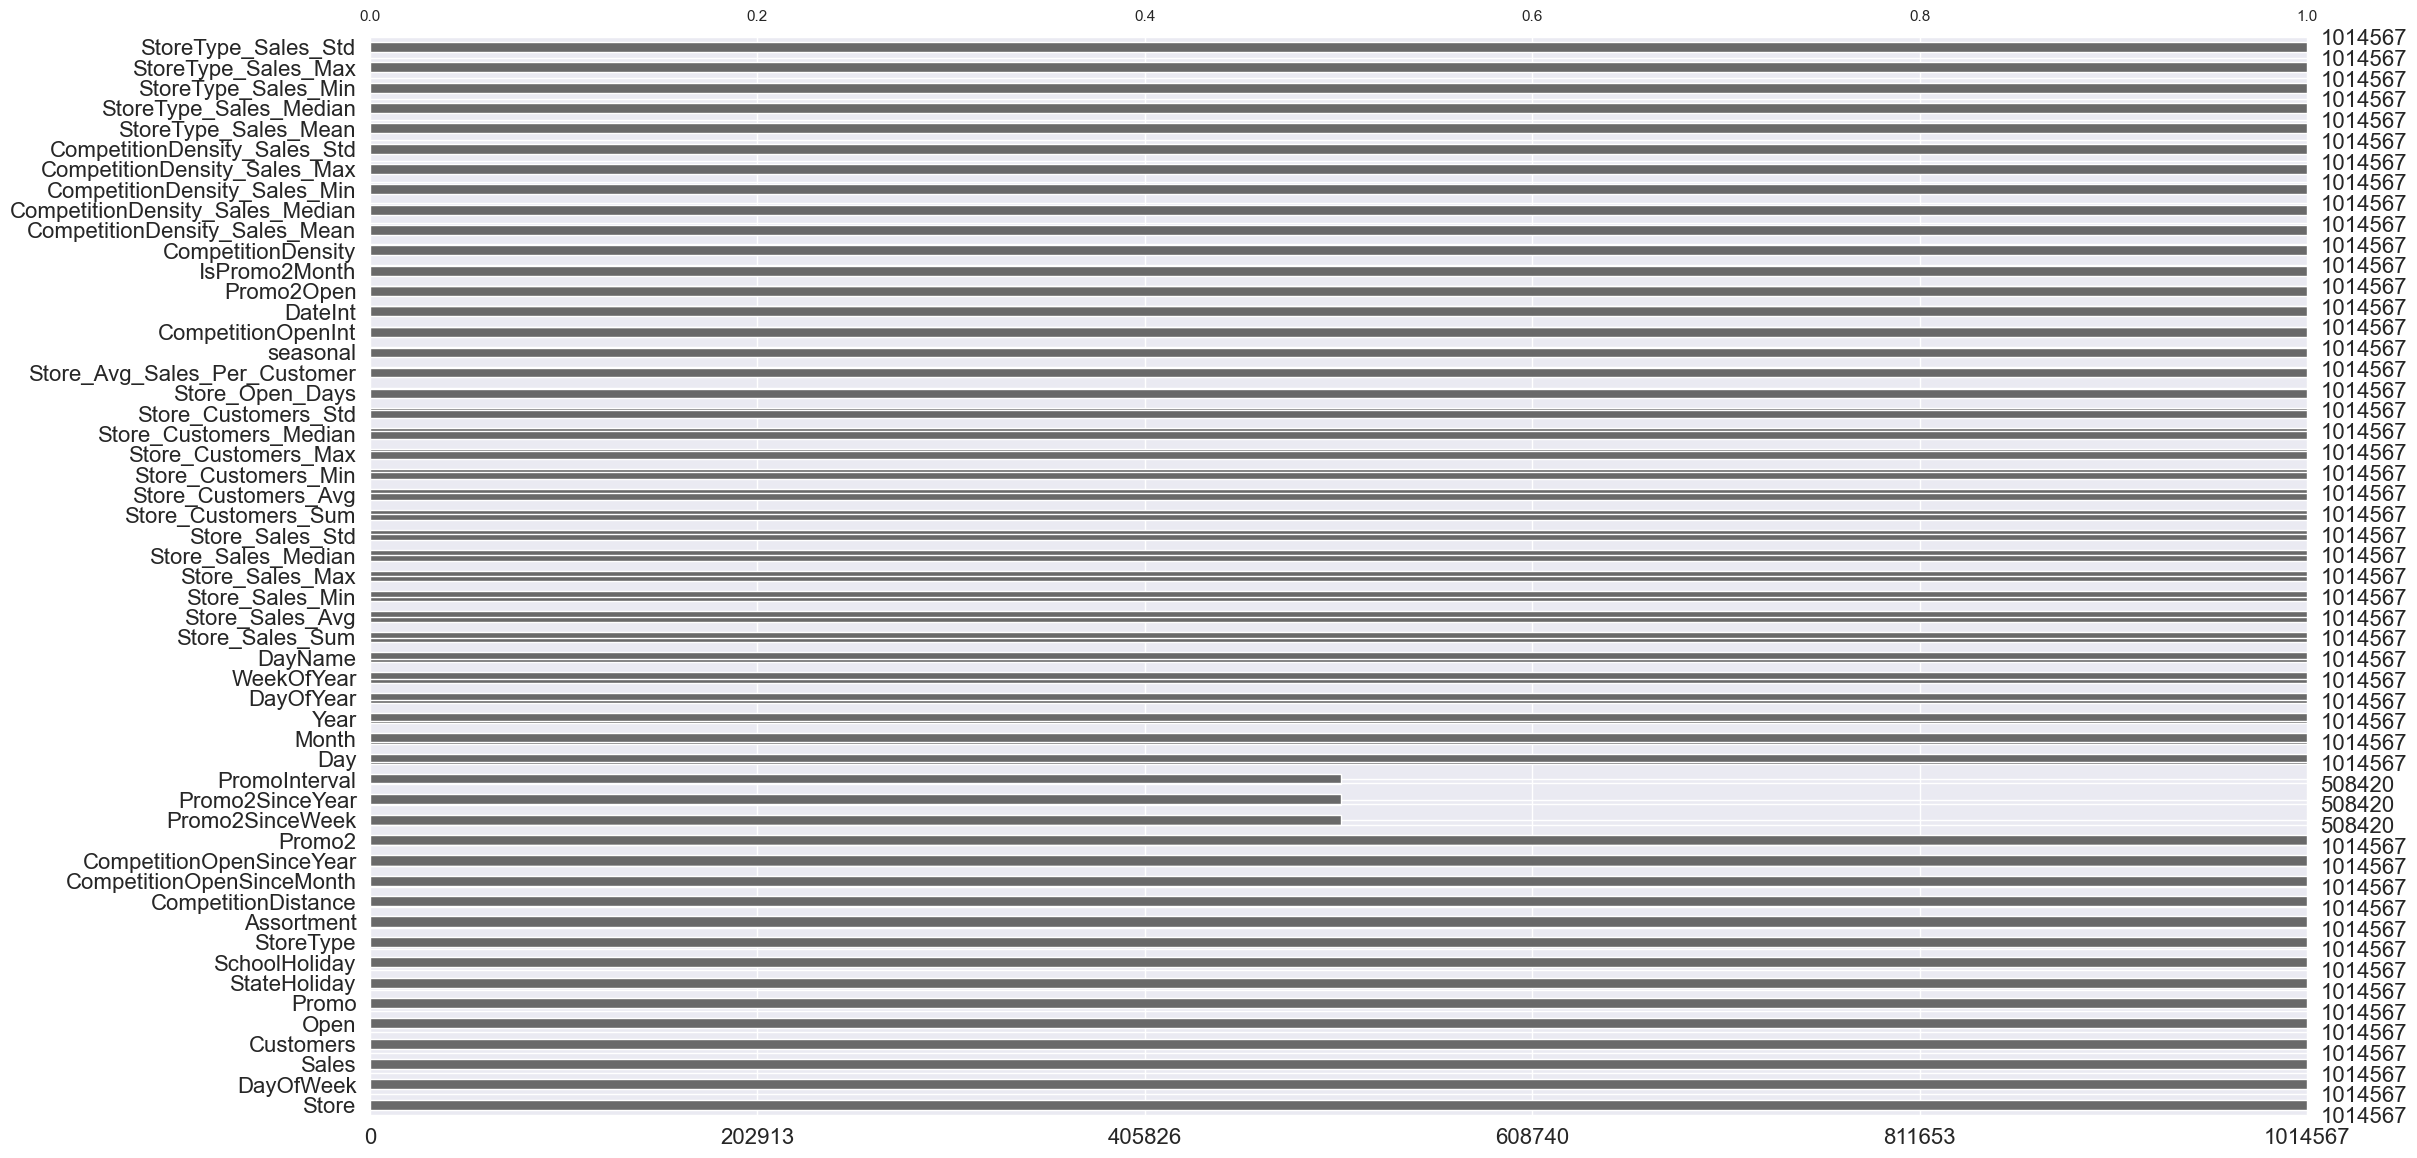

In [183]:
import missingno as msno

msno.bar(train_df)

In [129]:
merged_df.info()

NameError: name 'merged_df' is not defined

## Tiendas abiertas o cerradas

In [184]:
train_df.groupby(by='Open')['Sales'].sum()

Open
0             0
1    5861196794
Name: Sales, dtype: int64

Se eliminan los registros en los que la tienda esta cerrada. Luego serán harcodeados en test

In [185]:
train_df = train_df[train_df.Open == 1].copy() 
train_df.groupby(by='Open')['Sales'].sum()

Open
1    5861196794
Name: Sales, dtype: int64

Ya no hay tiendas cerradas en el dataset de entrenamiento

# Preparación de las variables objetivo y de entrenamiento

In [186]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'DayOfYear',
       'WeekOfYear', 'DayName', 'Store_Sales_Sum', 'Store_Sales_Avg',
       'Store_Sales_Min', 'Store_Sales_Max', 'Store_Sales_Median',
       'Store_Sales_Std', 'Store_Customers_Sum', 'Store_Customers_Avg',
       'Store_Customers_Min', 'Store_Customers_Max', 'Store_Customers_Median',
       'Store_Customers_Std', 'Store_Open_Days',
       'Store_Avg_Sales_Per_Customer', 'seasonal', 'CompetitionOpenInt',
       'DateInt', 'Promo2Open', 'IsPromo2Month', 'CompetitionDensity',
       'CompetitionDensity_Sales_Mean', 'CompetitionDensity_Sales_Median',
       'CompetitionDensity_Sales_Min', 'CompetitionDensity_Sales_Max',
       'CompetitionDensity_Sales_St

In [ ]:
# Selecting only the required columns which i think will be good for ML model.

input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [ ]:
# This created a dataframe with only columns names from the list we created above.

inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
inputs

In [ ]:
# Similarly doing the same for the test dataset
test_inputs = merged_test_df[input_cols].copy()
test_inputs

In [ ]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

# Impute missing numerical data


In [ ]:
inputs[numeric_cols]

In [ ]:
inputs[numeric_cols].isna().sum()

In [ ]:
test_inputs[numeric_cols].isna().sum()

In [ ]:
max_distance = inputs.CompetitionDistance.max()
max_distance

In [ ]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True) #Filling with 2X Highest value to indicate that the competition is non existent
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

In [ ]:
inputs[numeric_cols].isna().sum()

In [ ]:
test_inputs[numeric_cols].isna().sum()

# Escalar variables numericas

In [ ]:
inputs[numeric_cols].describe().loc[['min','max']]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(inputs[numeric_cols])

In [ ]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [ ]:
inputs[numeric_cols].describe().loc[['min','max']]

# Encoding de variables categoricas

In [ ]:
inputs[categorical_cols]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols].astype(str)) #This will handle unknown categories as separate one while Encoding values

In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols).astype(str))
encoded_cols

In [ ]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols].astype(str)) #merging the encoded columns onto out inputs dataset
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols].astype(str))
inputs[encoded_cols]

In [ ]:
# Since i was using a list of columns instead of modifying the actual data i can simply combine the ist to create new ones and use as a new filter list.

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X

# Gradient Boosting



### Training

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4) #for demonstration i'll be using very less estimators

In [ ]:
%%time

model.fit(X, targets)

# Prediction



In [ ]:
preds = model.predict(X)
preds

# Evaluation


In [ ]:
from sklearn.metrics import mean_squared_error

# just creating a helper function as we'll using this rmse to evaluate multiple models and paramaters futher down.
# Thus instead of writing this code again and again i'm creating this simple function.
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [ ]:
rmse(preds, targets)

# Visualization

In [ ]:
from xgboost import plot_tree

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR',ax=ax)
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR', num_trees=1,ax=ax)
plt.show(); #visualization of another tree

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR', num_trees=19,ax=ax)
plt.show(); #visualization of another tree

In [ ]:
trees = model.get_booster().get_dump()

print(trees[0])

# Feature importance

In [ ]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# Code not important just understand what we are trying to find.

models = []

def train_evaluate_and_predict(X, targets, **params): 
    kfold = KFold(n_splits=12)
    train_rmses = []
    val_rmses = []
    temp_models=[]
    n_estimators=0
    max_depth=0
    for i, (train_indexs, val_indexs) in enumerate(kfold.split(X)):
        X_train, train_targets = X.iloc[train_indexs], targets.iloc[train_indexs]
        X_val, val_targets = X.iloc[val_indexs], targets.iloc[val_indexs]
        model = XGBRegressor(random_state=42, n_jobs=-1, **params)
        model.fit(X_train, train_targets)
        train_rmse = rmse(model.predict(X_train), train_targets)
        val_rmse = rmse(model.predict(X_val), val_targets)
        temp_models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        n_estimators=params['n_estimators']
        max_depth=params['max_depth']
        print('Iteration {}, Train RMSE: {}, Validation RMSE: {}, Hyperparameters: n_estimators {}, max_depth {}'.format(i+1, train_rmse, val_rmse,n_estimators,max_depth))
        params['n_estimators'] += 1
        params['max_depth'] += 1
    return models.append(temp_models)

In [ ]:
train_evaluate_and_predict(X,targets,n_estimators=5,max_depth=4)

In [ ]:
# our current model we've using till now.
model

Since it may take a long time to perform training and prediction for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set. For this i used `train_test` split from sklearn. this is used to split any dataset into train and test datasets.

Your can read more about `train_test_split` [HERE](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).


After that we use a very similar function that we used above without **K-flod** to test the following hyperparameters.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [ ]:
def test_params(**params): 
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

This function takes in a dictionary of parameters (`**params`) as input and uses them to train and evaluate a gradient boosting model using the XGBRegressor class from the XGBoost library.

The function first creates an instance of the XGBRegressor class with three fixed hyperparameters: `n_jobs=-1` specifies that all available CPU cores should be used for training, `random_state=42` sets the random seed for reproducibility, and `**params` passes any additional hyperparameters to the model as a dictionary.

The XGBRegressor model is then trained using the `model.fit(X_train, train_targets)` method, where `X_train` is the training feature matrix and `train_targets` are the corresponding target values.

Next, the function calculates the root mean squared error (RMSE) between the predicted and actual target values for both the training and validation datasets, using a custom `rmse` function that is not shown in the code snippet. The RMSE metric is a common evaluation metric used for regression models, which measures the average distance between the predicted and actual target values, with lower values indicating better performance.

Finally, the function prints the training and validation RMSE scores using the `print` function. These scores provide a measure of how well the model is performing on both the training and validation datasets.

Overall, this function is a convenient way to test different hyperparameters for a gradient boosting model and evaluate their performance on a training and validation dataset. By passing different hyperparameters to the function, users can quickly experiment with different model configurations and identify the best combination of hyperparameters that results in the lowest RMSE score on the validation dataset.

### We'll try changing some of the parameters and see their effects below:

#### 1. `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [ ]:
test_params(n_estimators=10)

In [ ]:
test_params(n_estimators=30)

In [ ]:
test_params(n_estimators=50)

Notice the RMSE decrease as we change the value of the n_estimators?

Also remmeber the graph that we cannot just keep on increasing the n_estimators as at certain point the `train rmse` will keep on decrease while the `val rmse` will keep on increase. This is what it's called as "model overfitting" 

Model overfitting is a common problem in machine learning, where a model performs very well on the training data but poorly on new, unseen data. In other words, the model memorizes the training data rather than learning the underlying patterns that would allow it to generalize well to new data. 

Overfitting occurs when a model is too complex relative to the amount and quality of the training data. When a model is too complex, it can fit the noise in the training data, which leads to poor performance on new data. Overfitting can also occur when a model is trained for too long, which can lead to the model memorizing the training data instead of learning the underlying patterns.

Overfitting can be detected by comparing the model's performance on the training data to its performance on a separate validation dataset. If the model's performance on the validation data is significantly worse than its performance on the training data, the model is likely overfitting. 

There are several methods to avoid overfitting in XGBoost which we'll discuss later.

#### 2. `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [ ]:
test_params(max_depth=2)

In [ ]:
test_params(max_depth=5)

In [ ]:
test_params(max_depth=10)

#### 3.`learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In XGBoost, the learning rate is a hyperparameter that controls the step size at each iteration while moving toward a minimum of a loss function. The learning rate shrinks the feature weights in order to make the boosting process more conservative. The smaller the learning rate, the smaller steps the model takes and the more accurate the predictions, but this comes at the cost of longer training times.

A high learning rate can lead to faster training times but can also result in the model overshooting the optimal solution and ultimately leading to poorer performance. On the other hand, a low learning rate can help the model converge to the optimal solution, but it may take many iterations and result in longer training times.

Therefore, choosing the optimal learning rate is important to achieve both faster convergence and better performance. A typical range of learning rates for XGBoost is between 0.01 and 0.2, but the optimal value may depend on the specific problem being solved and other hyperparameters in the model. It's a good practice to experiment with different learning rates to find the optimal value for a given problem.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

In [ ]:
test_params(n_estimators=50, learning_rate=0.1)

In [ ]:
test_params(n_estimators=50, learning_rate=0.3)

In [ ]:
test_params(n_estimators=50, learning_rate=0.9)

In [ ]:
test_params(n_estimators=50, learning_rate=0.99)

#### 4. `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In XGBoost, the term "booster" refers to the type of model that is used for boosting. There are two types of boosters available in XGBoost: tree and linear.

The tree booster is a decision tree-based model that recursively splits data based on certain criteria, while the linear booster is a linear model that uses regularized linear regression. 

The default booster in XGBoost is "tree", which means the model will be a decision tree-based model. However, the "linear" booster can also be used if the data has a linear structure or if the number of features is very high.

In addition to the type of booster, XGBoost also allows for customization of the booster's parameters, such as the learning rate, maximum depth, and number of trees. These parameters can be tuned to improve the performance of the model.

In [ ]:
test_params(booster='gblinear')

Clearly, a linear model is not well suited for this dataset.

Similarly you can exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

### these helprer functions we create to find the best parameters from a set of parameters we gave as input:

**In machine learning "It's called as HYPERPARAMETER TUNING"**

Hyperparameter tuning refers to the process of selecting the optimal values for the hyperparameters of a machine learning model. Hyperparameters are parameters that are not learned during the training process but are set before training begins. Examples of hyperparameters in XGBoost include the learning rate, maximum depth of a tree, number of trees in the ensemble, regularization parameters, and more.

Hyperparameter tuning is important because it can significantly impact the performance of a model. Selecting appropriate values for hyperparameters can help to avoid overfitting or underfitting, and can improve the accuracy, precision, and recall of the model.

There are two main types of hyperparameter tuning: manual tuning and automated tuning.

1. **Manual tuning**: In manual tuning, the hyperparameters are selected based on the domain knowledge and experience of the user. The user tries different combinations of hyperparameters and evaluates the model's performance. The process can be time-consuming and requires a good understanding of the model and its hyperparameters.

2. **Automated tuning**: Automated tuning involves the use of algorithms to automatically search for the best hyperparameters. This can be done using techniques such as grid search, random search, or Bayesian optimization. Grid search involves specifying a range of values for each hyperparameter and trying all possible combinations. Random search involves randomly selecting hyperparameters from a given range of values. Bayesian optimization is a more sophisticated technique that uses a probabilistic model to search for the optimal hyperparameters.

Automated tuning is generally faster and can lead to better performance than manual tuning, but it requires more computational resources and may not always find the optimal hyperparameters. It is important to note that hyperparameter tuning is an iterative process and should be done in conjunction with other model selection and evaluation techniques such as cross-validation to ensure the model's performance is optimized.

In [ ]:
model = XGBRegressor(n_jobs=-1, random_state=42,n_estimators=1000,   # Some parameters I think will be good 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [ ]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1,train_size=0.2) 

model.fit(X_train, train_targets)
train_rmse = rmse(model.predict(X_train), train_targets)
val_rmse = rmse(model.predict(X_val), val_targets)
    
print("Train RMSE: {} and Validation RMSE: {}".format(train_rmse,val_rmse))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(32, input_dim=30, activation='relu'))  # input_dim=30 porque tienes 30 columnas de entrada
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # 1 neurona de salida porque estás haciendo una regresión

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X, targets.ravel(), epochs=50, batch_size=10)